# tracking job linearly through proc
proc allows us to track a job in a linear fashion through its run. So we will take a job and see how its statistics build over time.

Lifespan has promise as a way to train neural networks with epmt data

In [1]:
#import packages
import epmt_query as eq
import sys
sys.path.insert(0,'/home/Avery.Kiihne/pip_experiment')
import matplotlib.pyplot as plt
import numpy as np
import time
import matplotlib.animation as animation

In [2]:
#use orm format to get jobs and then feed to get_procs for a quicker run time
#need few jobs because each will be lasered in on
start = time.time()
job_num = 9
jobs_all = eq.get_jobs(limit = job_num,
                       before = -1,
                       fmt='orm') #format for passing to get_procs
procs_all = eq.get_procs(jobs = jobs_all,
                       fmt='dict')
print(f'number of elements in procs_all={len(procs_all)}')
print("time:",(time.time()-start)/60)

number of elements in procs_all=130532
time: 0.31357448498407997


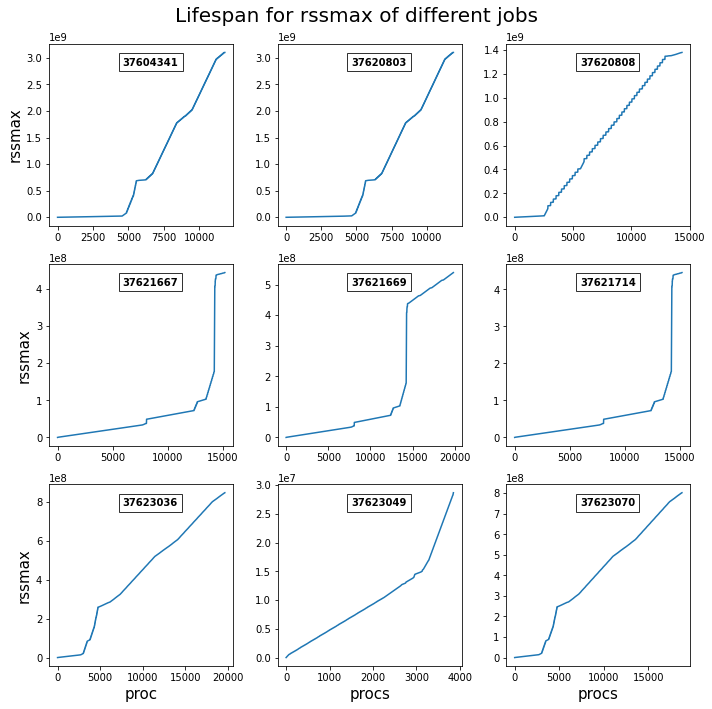

In [3]:
#make 3x3 grid of progressional plots for a variable
#variable_list = ['rssmax', 'cminflt',  'write_bytes',  'cancelled_write_bytes', 'minflt','rchar']
variable = 'rssmax'
plt.style.use('default')
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(10,10))
ax =ax.ravel() 
for job_instance in range(9):
    procs_of_job = eq.get_procs(jobs = jobs_all[job_instance], fmt='dict')
    total = 0
    progress = []
    proc_step = np.linspace(1,len(procs_of_job),len(procs_of_job))
    for proc_instance in range(len(procs_of_job)):
        total += procs_of_job[proc_instance][variable]
        progress.append(total)
    ax[job_instance].plot(proc_step,progress)
    ax[job_instance].annotate(procs_of_job[proc_instance]['jobid'], xy=(0.4, 0.9), xycoords="axes fraction",color = 'black', fontsize =10, weight = 'bold',horizontalalignment='left',verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('Lifespan for '+variable+' of different jobs',  fontsize = 20)
ax[0].set_ylabel(variable, fontsize = 15)
ax[3].set_ylabel(variable, fontsize = 15)
ax[6].set_ylabel(variable, fontsize = 15)
ax[6].set_xlabel('proc',fontsize = 15)
ax[7].set_xlabel('procs',fontsize = 15)
ax[8].set_xlabel('procs',fontsize = 15)
plt.tight_layout()

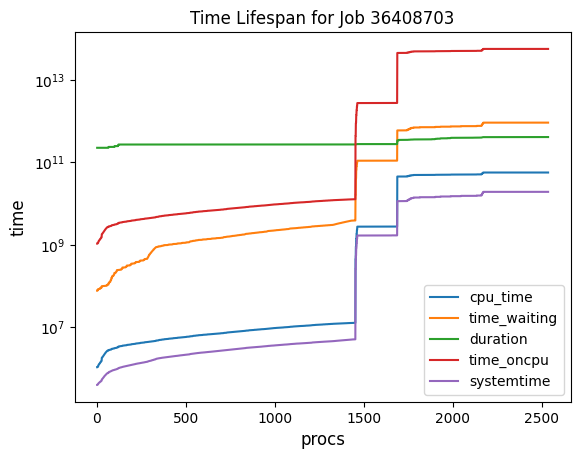

In [4]:
#several variables have matchig units, so I will make plots that combine numerous variables for a single job
factors = ['cpu_time', 'time_waiting', 'duration', 'time_oncpu','systemtime']
procs_of_job = eq.get_procs(jobs = jobs_all[1], fmt='dict')    #single random job
plt.style.use('default')

for fac in factors:
    total = 0
    progress = []
    proc_step = np.linspace(1,len(procs_of_job),len(procs_of_job))
    for proc_instance in range(len(procs_of_job)):
        total += procs_of_job[proc_instance][fac]
        progress.append(total)
    plt.plot(proc_step,progress, label = fac)
plt.yscale('log')
plt.ylabel('time', fontsize = 12)
plt.xlabel('procs', fontsize = 12)
plt.title('Time Lifespan for Job '+procs_of_job[proc_instance]['jobid'])
plt.legend()
plt.show()

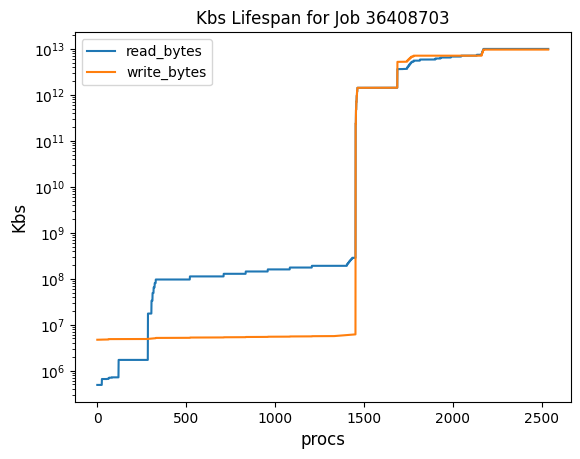

In [5]:
#several factors have matchig units, so I will make plots that combine numerous factors for a single job
factors = ['read_bytes','write_bytes']
procs_of_job = eq.get_procs(jobs = jobs_all[1], fmt='dict')    #single random job
plt.style.use('default')

for fac in factors:
    total = 0
    progress = []
    proc_step = np.linspace(1,len(procs_of_job),len(procs_of_job))
    for proc_instance in range(len(procs_of_job)):
        total += procs_of_job[proc_instance][fac]
        progress.append(total)
    plt.plot(proc_step,progress, label = fac)
plt.yscale('log')
plt.ylabel('Kbs', fontsize = 12)
plt.xlabel('procs', fontsize = 12)
plt.title('Kbs Lifespan for Job '+procs_of_job[proc_instance]['jobid'])
plt.legend()
plt.show()

# neural net approach
I want a neural network that can take part of lifespan and use it to predict final rssmax or duration or something else that would imply failure

In [12]:
#use orm format to get jobs and then feed to get_procs for a quicker run time
#need few jobs because each will be lasered in on

start = time.time()

import sys
sys.path.insert(0,'/home/Ian.Laflotte/ians_py374/pip_experiment')
import matplotlib.pylab as plt

import importlib
skl_spec= importlib.util.spec_from_file_location('sklearn','/home/Ian.Laflotte/ians_py374/pip_experiment/sklearn/__init__.py')
sklearn = importlib.util.module_from_spec(skl_spec)
skl_spec.loader.exec_module(sklearn) 

# skl should now be callable
#help(skl)
sklearn.__version__

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
job_num = 15000
jobs_all = eq.get_jobs(limit = job_num,
                       before = -7,
                       fmt='orm') #format for passing to get_procs
#procs_all = eq.get_procs(jobs = jobs_all, fmt='dict')
print(f'number of elements in procs_all={len(procs_all)}')
print("time:",(time.time()-start)/60)

number of elements in procs_all=36315
time: 0.0006465673446655274


In [13]:
#want to make an array with each entry being an array, and each entry in that array is a time ordered list from lifespan
top_array = []
factors = ['cpu_time','write_bytes','duration']
final_rssmax = []
for job_instance in range(job_num):
    real_job = eq.get_jobs(jobs = jobs_all[job_instance], fmt = 'dct')
    final_rssmax.append(real_job[0]['rssmax'])
    #setup arrays and dictionaries to fill all data in one proc loop
    top_array.append([])
    total = {}
    procs_of_job = eq.get_procs(jobs = jobs_all[job_instance], fmt='dict')
    top_array[len(top_array)-1].append(np.linspace(1,len(procs_of_job),len(procs_of_job)))
    for fac in factors:
        top_array[job_instance].append([])
        total[fac] = 0
    for proc_instance in range(len(procs_of_job)):
        counter = 1   #counts which number factor we are on 
        for fac in factors:
            total[fac] += procs_of_job[proc_instance][fac]
            top_array[job_instance][counter].append(total[fac])
            counter += 1

In [14]:
'''#make the models
x_train, x_test, y_train, y_test = train_test_split(
  top_array,final_rssmax , random_state=104,test_size=0.25, shuffle=True)

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
classifier_knn = KNeighborsClassifier(n_neighbors = 5)
classifier_knn.fit(x_train,y_train)
prediction = classifier_knn.predict(x_test)
#chi squared
chi_squared = 0
for aa in range(len(prediction)):
    chi_squared += (prediction[aa]-y_test[aa])**2/y_test[aa]
'''

'#make the models\nx_train, x_test, y_train, y_test = train_test_split(\n  top_array,final_rssmax , random_state=104,test_size=0.25, shuffle=True)\n\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom sklearn import metrics\nclassifier_knn = KNeighborsClassifier(n_neighbors = 5)\nclassifier_knn.fit(x_train,y_train)\nprediction = classifier_knn.predict(x_test)\n#chi squared\nchi_squared = 0\nfor aa in range(len(prediction)):\n    chi_squared += (prediction[aa]-y_test[aa])**2/y_test[aa]\n'

In [15]:
'''#plotting
plt.style.use('default')
plt.scatter(prediction,y_test,s = 10)
plt.ylabel('true rssmax')
plt.xlabel('predicted rssmax')
plt.title('neighbors classifier test')
plt.yscale('log')
plt.xscale('log')
plt.xlim(.8*min(min(y_test),min(prediction)),1.2*max(max(y_test),max(prediction)))
plt.ylim(.8*min(min(y_test),min(prediction)),1.2*max(max(y_test),max(prediction)))
plt.annotate(r'$\chi^2=$'+str("{:e}".format(chi_squared)),(.15,.83), color = 'black', fontsize =12,horizontalalignment='left',verticalalignment='center', xycoords='figure fraction')
plt.tight_layout()
plt.show()'''

'#plotting\nplt.style.use(\'default\')\nplt.scatter(prediction,y_test,s = 10)\nplt.ylabel(\'true rssmax\')\nplt.xlabel(\'predicted rssmax\')\nplt.title(\'neighbors classifier test\')\nplt.yscale(\'log\')\nplt.xscale(\'log\')\nplt.xlim(.8*min(min(y_test),min(prediction)),1.2*max(max(y_test),max(prediction)))\nplt.ylim(.8*min(min(y_test),min(prediction)),1.2*max(max(y_test),max(prediction)))\nplt.annotate(r\'$\\chi^2=$\'+str("{:e}".format(chi_squared)),(.15,.83), color = \'black\', fontsize =12,horizontalalignment=\'left\',verticalalignment=\'center\', xycoords=\'figure fraction\')\nplt.tight_layout()\nplt.show()'

# simplified prediction
Due to the complexity of the above problem, we will do a simplified version. Take the sum of factors at the midway point, and predict the final rssmax.
This means we train on all arrays of equal length instead of a whole matrix for each final_rssmax.

In [16]:
#break data into sum of first half for each factor, then into train vs test data
middle_sums = []
for job_instance in range(job_num):
    middle_sums.append([])
    length = max(top_array[job_instance][0])    #length of total array. used to cut in half
    for fac_instance in range(len(factors)+1):
        middle_sums[job_instance].append(max(top_array[job_instance][fac_instance][0:int(length/2)]))
x_train, x_test, y_train, y_test = train_test_split(
  middle_sums,final_rssmax ,test_size=0.25, shuffle=True)

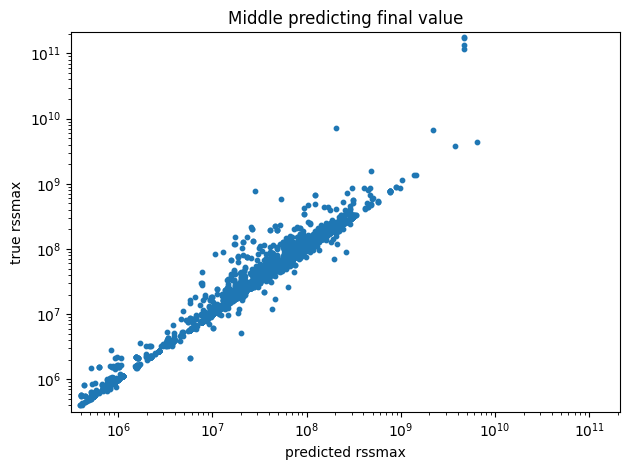

1.695760e+10


In [17]:
#apply nearest neighbors model
#redo Neighbors with quantile transform
#this will rescale the x_train and test data, allowing for different axis to match, and minimize impact of outliers
from sklearn.preprocessing import QuantileTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
trans = QuantileTransformer(n_quantiles=100, output_distribution='normal')
trans.fit(x_train)
x_train_transformed = trans.transform(x_train)
x_test_transformed = trans.transform(x_test)
classifier_knn = KNeighborsClassifier(n_neighbors = 5)
classifier_knn.fit(x_train_transformed,y_train)
prediction = classifier_knn.predict(x_test_transformed)
#chi squared
chi_squared = 0
for aa in range(len(prediction)):
    chi_squared += (prediction[aa]-y_test[aa])**2/y_test[aa]
#plt.annotate(r'$\chi^2=$'+str("{:e}".format(chi_squared)),(.15,.83), color = 'black', fontsize =12,horizontalalignment='left',verticalalignment='center', xycoords='figure fraction')
plt.style.use('default')
plt.scatter(prediction,y_test, s = 10)
plt.ylabel('true rssmax')
plt.xlabel('predicted rssmax')
plt.title('Middle predicting final value')
plt.yscale('log')
plt.xscale('log')
plt.xlim(.80*min(min(y_test),min(prediction)),1.20*max(max(y_test),max(prediction)))
plt.ylim(.80*min(min(y_test),min(prediction)),1.20*max(max(y_test),max(prediction)))
plt.tight_layout()
plt.savefig('analysis_plots/midpoint_prediction.pdf', format = 'pdf', bbox_inches='tight')
plt.show()

print(str("{:e}".format(chi_squared)))